In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv("time_series_covid19_deaths_US.csv")
df = df.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis = 1)
df2 = df.groupby('Province_State').sum()
pop = df2['Population']
df2 = df2.drop('Population', axis = 1)
df3 = df2
for x in list(df3.columns): 
  df3[x] = df3[x] / pop 
df3 = df3.drop([x for x in df3.index if 'Princess' in x])

L=np.array(df3.values.tolist())

In [ ]:
L.shape

(56, 1036)

In [ ]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tslearn.clustering import TimeSeriesKMeans

nbclus=10
model = TimeSeriesKMeans(n_clusters=nbclus, metric="dtw", max_iter=10)
prediction = model.fit_predict(L)
 
print(prediction)

[2 5 4 2 2 3 3 8 8 5 6 6 3 7 0 0 6 8 8 6 6 5 3 8 6 3 2 8 8 3 6 5 6 2 6 3 0
 9 8 2 5 6 1 8 6 8 2 0 1 7 7 3 5 2 3 8]


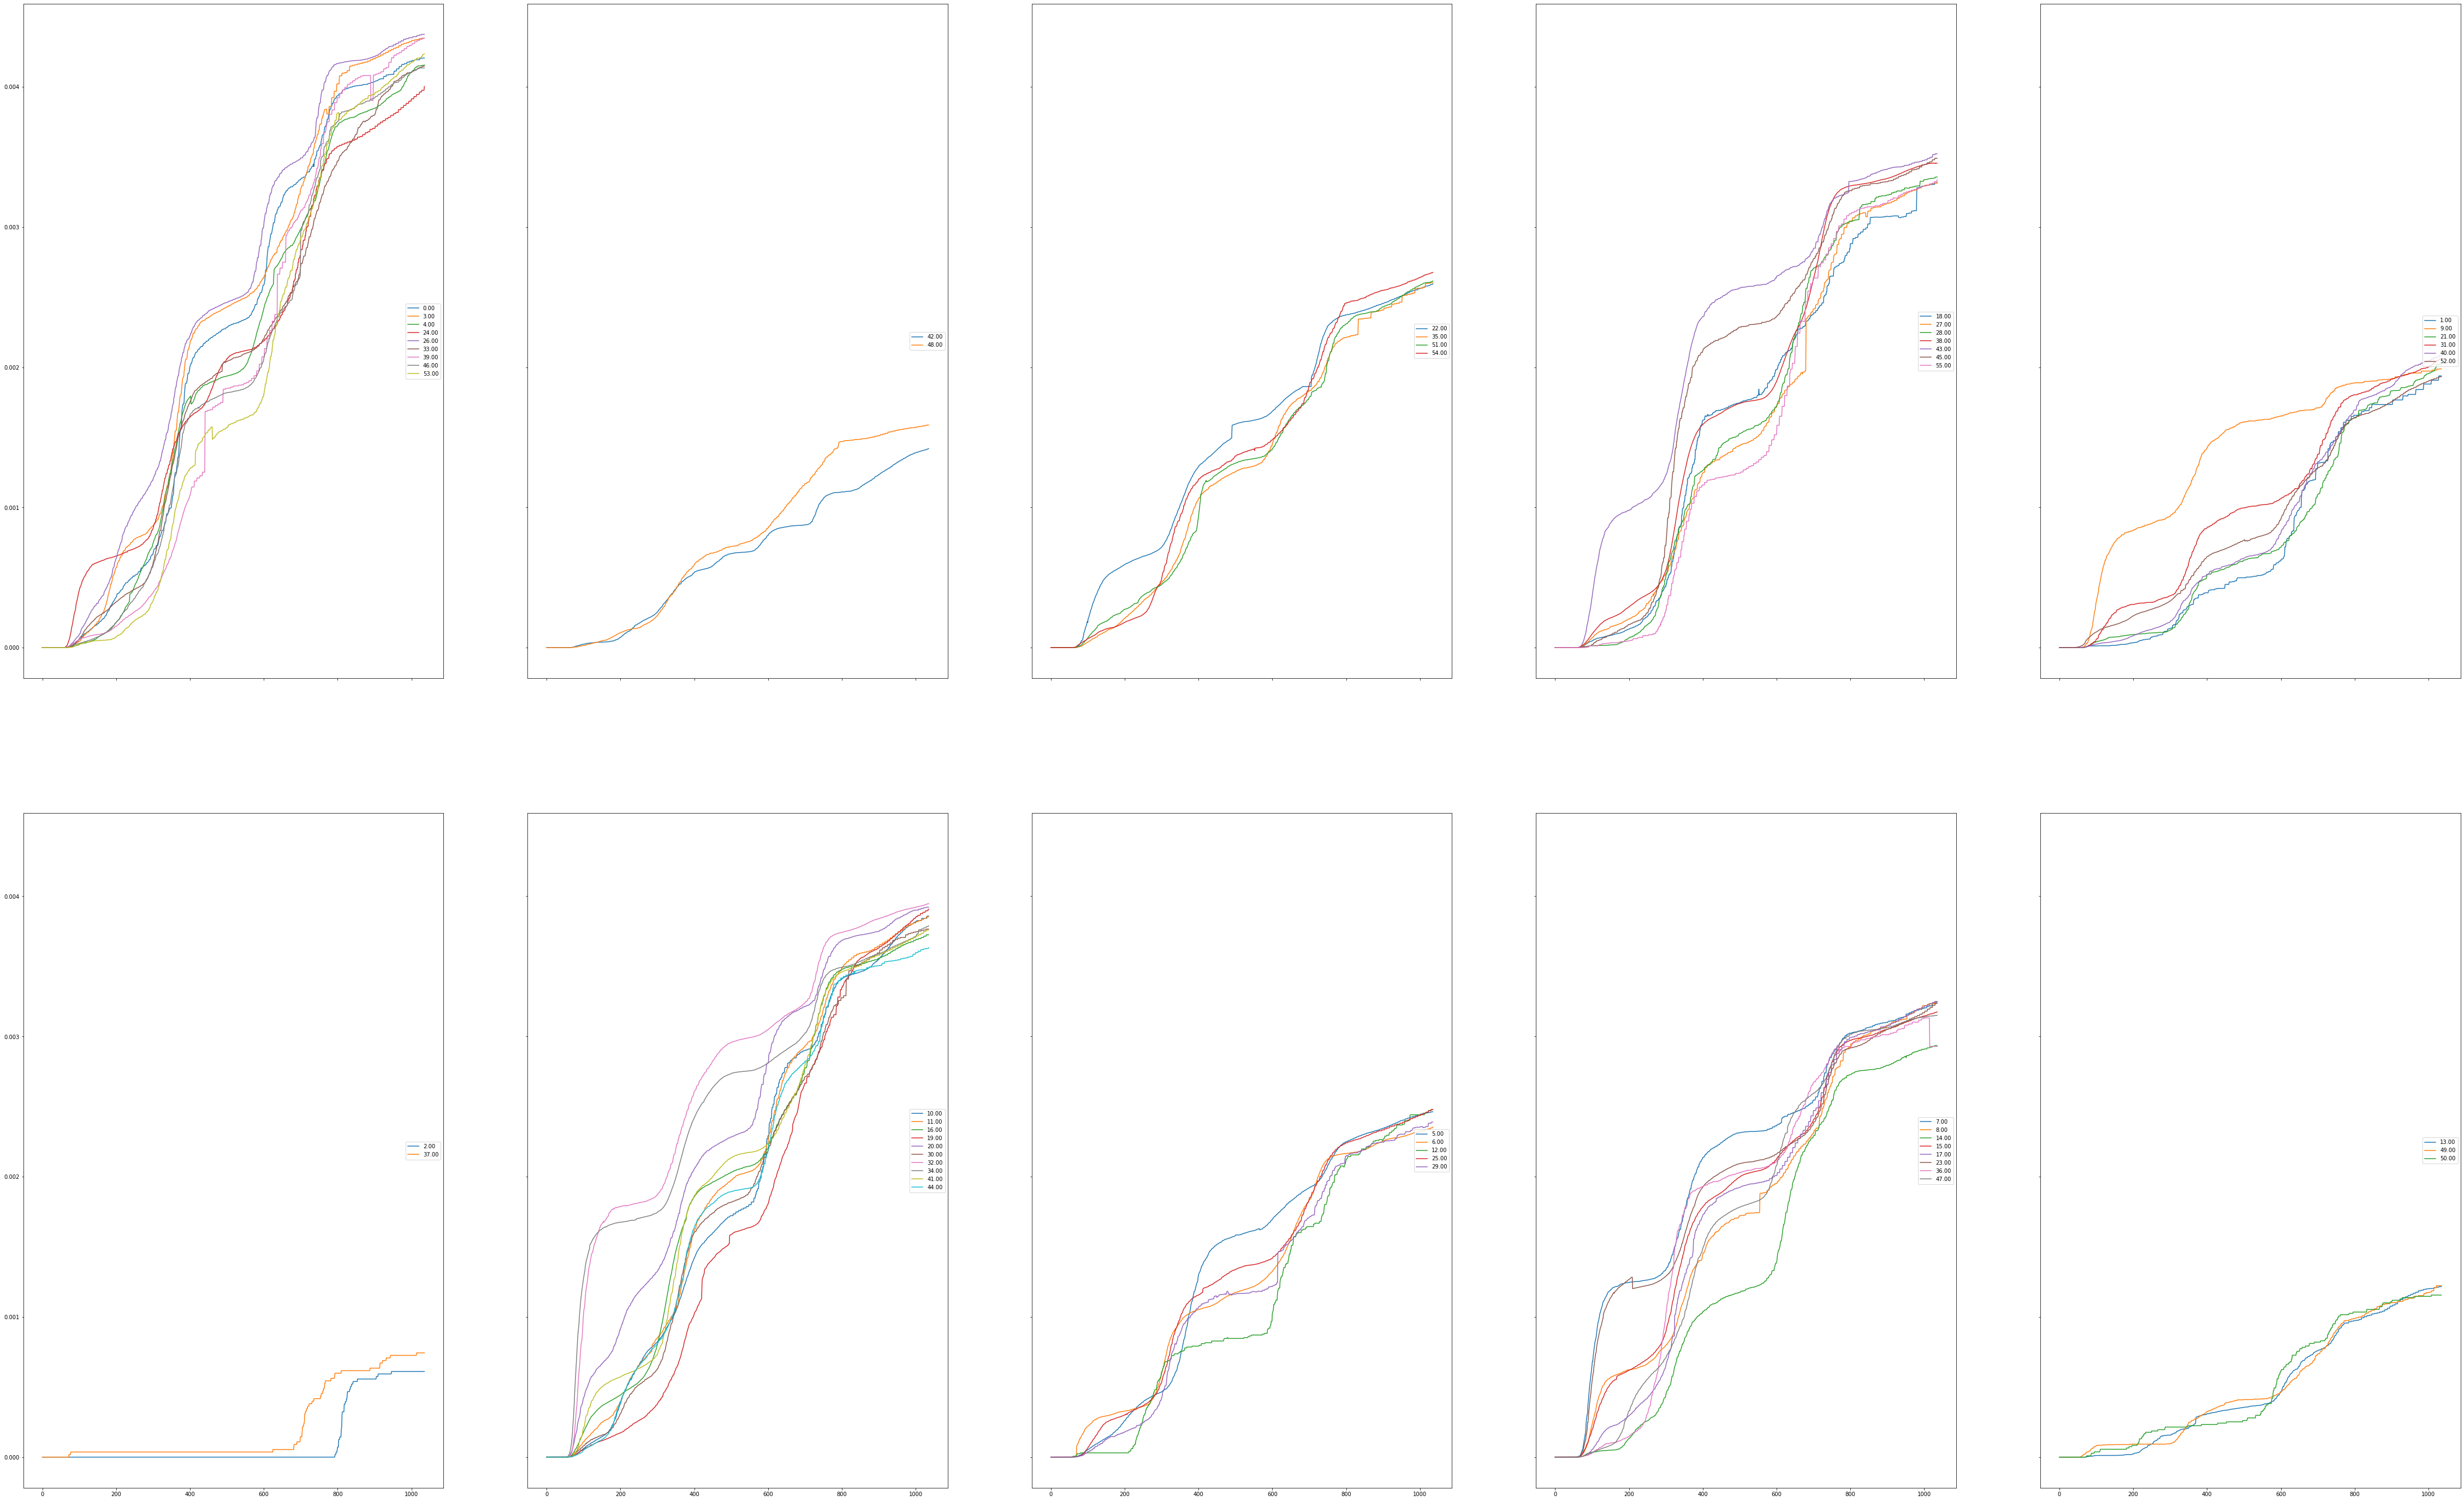

In [ ]:
fig,axes=plt.subplots(2,5, figsize=(80,50), sharex=True, sharey=True)

for k in range(len(prediction)):
  i=prediction[k]
  axes[i//5, i%5].plot(L[k], label='%.2f'%k)
  axes[i//5, i%5].legend(loc='right')

plt.show()

# première version

### pas fiable


In [ ]:
from tensorflow import keras

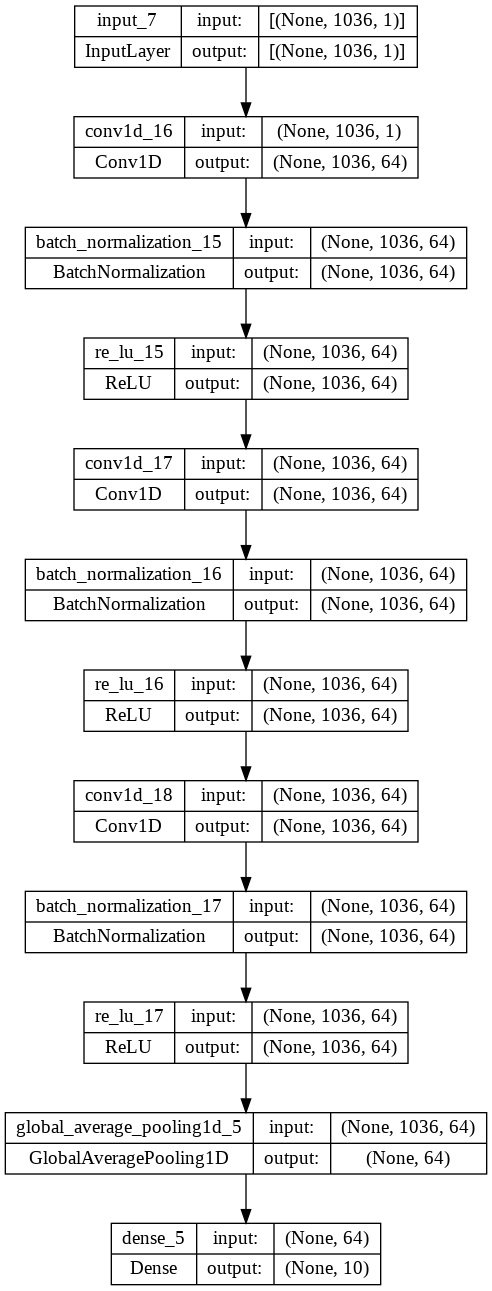

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(nbclus, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=L.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 300
batch_size = 32


callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    L,
    prediction,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/300
2/2 [==============================] - 2s 430ms/step - loss: 2.3877 - sparse_categorical_accuracy: 0.0227 - val_loss: 2.3023 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/300
2/2 [==============================] - 0s 184ms/step - loss: 2.1571 - sparse_categorical_accuracy: 0.1364 - val_loss: 2.3020 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/300
2/2 [==============================] - 0s 183ms/step - loss: 1.9729 - sparse_categorical_accuracy: 0.3864 - val_loss: 2.3018 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/300
2/2 [==============================] - 0s 169ms/step - loss: 1.8885 - sparse_categorical_accuracy: 0.4318 - val_loss: 2.3021 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/300
2/2 [==============================] - 0s 139ms/step - loss: 1.8325 - sparse_categorical_accuracy: 0.4091 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/300
2/2 [===

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(L, prediction)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2/2 [==============================] - 0s 44ms/step - loss: 2.2045 - sparse_categorical_accuracy: 0.1786
Test accuracy 0.1785714328289032
Test loss 2.2045352458953857


In [ ]:
pred = model.predict(L)
res = []
for p in pred:
    res.append(p.argmax())
res=np.array(res)
print('evaluation', res)
print('correction', prediction)
print(np.all(res==prediction))

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 56 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


evaluation [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
correction [6 0 5 6 6 4 4 3 3 0 1 1 4 2 9 3 8 3 3 1 1 0 4 3 1 4 6 3 3 4 1 0 1 6 1 4 3
 5 8 6 0 1 7 8 8 8 6 3 7 2 2 4 0 6 4 3]
False



# Deuxième version

In [ ]:
from sklearn.svm import SVC

In [ ]:
cls=SVC().fit(L,prediction)

In [ ]:
cls.predict(L)

array([6, 5, 7, 6, 6, 3, 3, 8, 8, 3, 6, 6, 3, 5, 8, 8, 6, 8, 8, 8, 6, 5,
       3, 8, 6, 3, 6, 8, 8, 3, 8, 3, 6, 6, 6, 3, 8, 7, 8, 6, 5, 6, 5, 6,
       8, 8, 6, 8, 5, 5, 5, 3, 5, 6, 3, 8])

In [ ]:
#taux de précision
sum(prediction==cls.predict(L))/len(prediction)

0.5535714285714286

# Troisième version

### plutôt fiable

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(L,prediction)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
clf.predict(L)

array([2, 5, 7, 2, 2, 3, 3, 8, 8, 3, 6, 6, 3, 7, 3, 8, 6, 8, 8, 8, 6, 5,
       3, 8, 6, 3, 2, 8, 8, 3, 6, 5, 6, 6, 6, 3, 8, 7, 8, 2, 5, 6, 5, 8,
       6, 8, 2, 8, 5, 7, 7, 3, 5, 2, 3, 8])

In [ ]:
#taux de précision
sum(prediction==clf.predict(L))/len(prediction)

0.8035714285714286